In [14]:
import matplotlib
#matplotlib.use("Agg")

# import the necessary packages
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.applications.resnet import ResNet50

from tensorflow.keras.layers import Input
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import AveragePooling2D, Dropout, Flatten, Dense
#from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
#from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import argparse
import pickle
import cv2
import os
from sklearn.metrics import confusion_matrix
from sklearn.utils.multiclass import unique_labels


In [15]:
import tensorflow as tf

In [16]:
from sklearn import preprocessing
import numpy as np
import matplotlib.pyplot as plt
import cv2
from sklearn.preprocessing import LabelBinarizer

In [17]:
from skimage.io import imread, imshow
from skimage.transform import resize
from skimage.feature import hog
from skimage import exposure

In [19]:
x=np.load("../data.csv.npy")
y=np.load("../labels.npy")

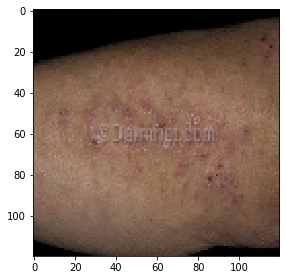

In [12]:
imshow(x[0])

In [24]:
lb = LabelBinarizer()
y= lb.fit_transform(y)
print(x.shape, y.shape)

(4428, 224, 224, 3) (4428, 4)


In [27]:
(trainX, testX, trainY, testY) = train_test_split(x, y,
test_size=0.20, stratify=y, random_state=42)

In [46]:
trainAug = ImageDataGenerator(
	rotation_range=30,
	zoom_range=0.15,
	width_shift_range=0.2,
	height_shift_range=0.2,
	shear_range=0.15,
	horizontal_flip=True,
	fill_mode="nearest")
valAug = ImageDataGenerator()
mean = np.array([123.68, 116.779, 103.939], dtype="float32")
trainAug.mean = mean
valAug.mean = mean

In [53]:
baseModel = ResNet50(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

for layer in baseModel.layers:
	layer.trainable = False


headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(7, 7))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(512, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(len(lb.classes_), activation="softmax")(headModel)

model = Model(inputs=baseModel.input, outputs=headModel)

In [54]:
print("[INFO] compiling model...")
opt = SGD(lr=1e-4, momentum=0.9, decay=1e-4 / 25)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=32),
	steps_per_epoch=len(trainX) // 32,
	validation_data=valAug.flow(testX, testY),
	validation_steps=len(testX) // 32,
	epochs=25)

[INFO] compiling model...
[INFO] training head...
Epoch 1/25
110/110 [==============================] - 190s 2s/step - loss: 1.2644 - accuracy: 0.5017 - val_loss: 0.5640 - val_accuracy: 0.8218
Epoch 2/25
110/110 [==============================] - 182s 2s/step - loss: 0.6625 - accuracy: 0.7427 - val_loss: 0.3798 - val_accuracy: 0.8831
Epoch 3/25
110/110 [==============================] - 164s 1s/step - loss: 0.5420 - accuracy: 0.7926 - val_loss: 0.3166 - val_accuracy: 0.8981
Epoch 4/25
110/110 [==============================] - 164s 1s/step - loss: 0.4520 - accuracy: 0.8305 - val_loss: 0.2699 - val_accuracy: 0.9120
Epoch 5/25
110/110 [==============================] - 165s 1s/step - loss: 0.4062 - accuracy: 0.8459 - val_loss: 0.2555 - val_accuracy: 0.9132
Epoch 6/25
110/110 [==============================] - 165s 2s/step - loss: 0.3734 - accuracy: 0.8613 - val_loss: 0.2382 - val_accuracy: 0.9178
Epoch 7/25
110/110 [==============================] - 165s 2s/step - loss: 0.3479 - accuracy

In [55]:
from tensorflow.keras.models import load_model
model.save('disaster_classification_pkl.pkl')

G:\ANACONDA\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: disaster_classification_pkl.pkl\assets


In [56]:
model.save('disaster_hdf5.hd5')


G:\ANACONDA\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


INFO:tensorflow:Assets written to: disaster_hdf5.hd5\assets


In [58]:
score_training=model.evaluate_generator((testX,trainY), 
                         steps=10, 
                         verbose=0)
print("Loss of trained model :",score_training[0])
print("Accuracy of trained model :",score_training[1])

ValueError: Data cardinality is ambiguous:
  x sizes: 886, 3542
Make sure all arrays contain the same number of samples.

In [59]:
testX.shape

(886, 224, 224, 3)

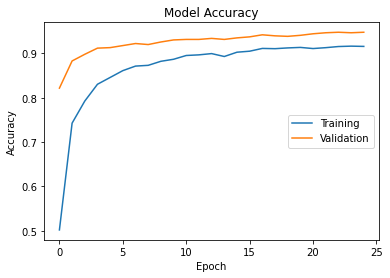

In [64]:
plt.plot(H.history['accuracy'])
plt.plot(H.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='center right')
plt.show()

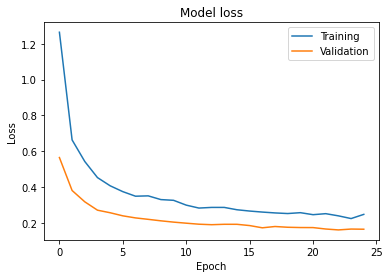

In [65]:
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')
plt.show()

In [1]:
from tensorflow.keras.models import load_model

In [12]:
model =load_model('disaster_hdf5.hd5')

In [13]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [ ]:
from joblib import dump,load
dump(model,'disease_classification.pkl')

In [11]:
import pickle

In [12]:
saved_model = pickle.dumps(model)

AttributeError: Can't pickle local object 'Loader._recreate_base_user_object.<locals>._UserObject'

In [4]:
model.save("network.h5")

G:\ANACONDA\lib\site-packages\tensorflow\python\keras\utils\generic_utils.py:494: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  warnings.warn('Custom mask layers require a config and must override '


In [5]:
model=load_model("network.h5")

In [6]:
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
conv1_pad (ZeroPadding2D)       (None, 230, 230, 3)  0           input_3[0][0]                    
__________________________________________________________________________________________________
conv1_conv (Conv2D)             (None, 112, 112, 64) 9472        conv1_pad[0][0]                  
__________________________________________________________________________________________________
conv1_bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1_conv[0][0]                 
____________________________________________________________________________________________

In [10]:
import pickle
pickle.load('disaster_classification_pkl.pkl')

TypeError: file must have 'read' and 'readline' attributes